In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error

**Load and preprocess data**

In [2]:
df = pd.read_csv("preprocessed_crime_data.csv")
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month

** Aggregate monthly crime count per zone**

In [3]:
monthly_zone_crime = df.groupby(['Year', 'Month', 'Rpt Dist No'])['Crime Count'].sum().reset_index()

**Features and target**

In [4]:
feature_cols = ['Year', 'Month', 'Rpt Dist No']
X = monthly_zone_crime[feature_cols]
y = monthly_zone_crime['Crime Count']

**Split train/test**

In [5]:
train_mask = X['Year'] < 2024
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

** Parameter grid**

In [6]:
param_grid = [
    {'max_iter': 100, 'learning_rate': 0.1, 'max_depth': 3},
    {'max_iter': 200, 'learning_rate': 0.05, 'max_depth': 4},
    {'max_iter': 300, 'learning_rate': 0.01, 'max_depth': 6},
    {'max_iter': 150, 'learning_rate': 0.15, 'max_depth': 3},
    {'max_iter': 120, 'learning_rate': 0.1, 'max_depth': 5},
    {'max_iter': 250, 'learning_rate': 0.05, 'max_depth': 7},
    {'max_iter': 180, 'learning_rate': 0.08, 'max_depth': 4},
    {'max_iter': 300, 'learning_rate': 0.1, 'max_depth': 6},
    {'max_iter': 200, 'learning_rate': 0.02, 'max_depth': 8},
    {'max_iter': 100, 'learning_rate': 0.2, 'max_depth': 2},
]


**Run and evaluate each model**

In [7]:

results = []

for i, params in enumerate(param_grid, 1):
    model = HistGradientBoostingRegressor(
        max_iter=params['max_iter'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    X_test_copy = X_test.copy()
    X_test_copy['Predicted Crime Count'] = y_pred
    zone_preds = X_test_copy.groupby('Rpt Dist No')['Predicted Crime Count'].sum().reset_index()
    most_dangerous = zone_preds.sort_values(by='Predicted Crime Count', ascending=False).iloc[0]

    results.append({
        'Model': i,
        'Max Iter': params['max_iter'],
        'Learning Rate': params['learning_rate'],
        'Max Depth': params['max_depth'],
        'Rpt Dist No': most_dangerous['Rpt Dist No'],
        'Predicted Crime Count': most_dangerous['Predicted Crime Count'],
        'MSE': mse
    })

In [8]:
results_df = pd.DataFrame(results)

print("\n Model Evaluation Summary:")
print(results_df.sort_values(by='MSE').to_string(index=False))


 Model Evaluation Summary:
 Model  Max Iter  Learning Rate  Max Depth  Rpt Dist No  Predicted Crime Count      MSE
     3       300           0.01          6        991.0              33.011724 1.025054
     1       100           0.10          3        991.0              30.592858 1.039997
     9       200           0.02          8        989.0              37.407431 1.040924
     2       200           0.05          4        989.0              38.567744 1.045511
     4       150           0.15          3        989.0              38.622426 1.045530
    10       100           0.20          2        991.0              32.154313 1.051424
     7       180           0.08          4        990.0              41.760491 1.051946
     5       120           0.10          5        991.0              43.439997 1.058323
     6       250           0.05          7        990.0              44.232850 1.067813
     8       300           0.10          6        991.0              43.661748 1.068149


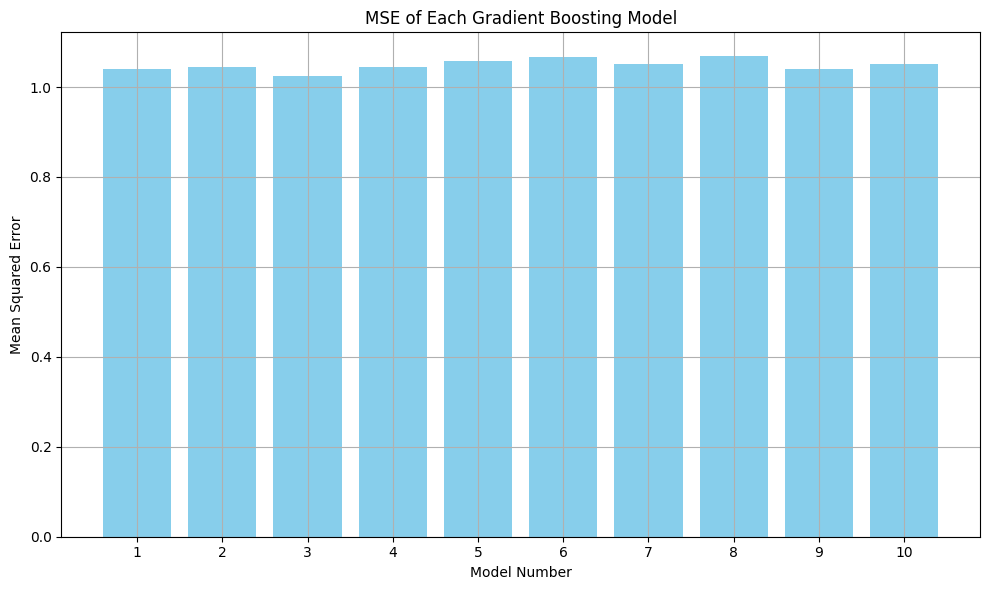

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['MSE'], color='skyblue')
plt.xlabel('Model Number')
plt.ylabel('Mean Squared Error')
plt.title('MSE of Each Gradient Boosting Model')
plt.xticks(results_df['Model'])
plt.grid(True)
plt.tight_layout()
plt.show()
